In [1]:
# Just the normal prequisites for using matplotlib and numpy in a Jupyter notebook
%matplotlib inline
# Use the svg backend, in my opinion it just makes better looking plots
%config InlineBackend.figure_format = 'svg'
%load_ext itikz

import PySpice.Logging.Logging as Logging
logger = Logging.setup_logging( logging_level='CRITICAL')

import os
import sys
from pathlib import Path
import IPython
from scipy import signal
import scipy.fftpack
from PySpice.Unit import *
from PySpice.Spice.Parser import SpiceParser
from PySpice.Spice.Netlist import Circuit, SubCircuit, SubCircuitFactory
from PySpice.Spice.Library import SpiceLibrary
from PySpice.Probe.Plot import plot
from PySpice.Doc.ExampleTools import find_libraries
from PySpice.Math import *
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import matplotlib.pyplot as plt
import unittest

import schemdraw
import schemdraw.elements as elm
from schemdraw import logic
from schemdraw import dsp

directory_path = Path(os.path.abspath('')).resolve().parent.parent
spice_libraries_path = directory_path.joinpath("lib", "spice")
spice_library = SpiceLibrary(spice_libraries_path)

directory_path = Path(os.path.abspath('')).resolve()

import json
from IPython.display import display, HTML
from IPython.display import Javascript

display(HTML('''
<script src="https://cdnjs.cloudflare.com/ajax/libs/Chart.js/3.5.0/chart.min.js" integrity="sha512-asxKqQghC1oBShyhiBwA+YgotaSYKxGP1rcSYTDrB0U6DxwlJjU59B67U8+5/++uFjcuVM8Hh5cokLjZlhm3Vg==" crossorigin="anonymous" referrerpolicy="no-referrer"></script>
'''))

# wavetable synthesis

Wavetable synthesis is a very simple approach to reproduce a periodic waveform with a microprocessor. Calculating a periodic waveform is a ressource intensive task. All the values in the waveform a pre-calculated and stored in a table (the wave table). all that has to be done now, is to replay this values and send it to a digital to analog converter (DAC).

The wavetable contains one cycle of the waveform. to get a continous waveform the values are played in a loop.

In [2]:
wavetable = []
linespace = np.arange(0, 1, (1/1024))
for s in linespace :
    wavetable.append(np.sin(2*np.pi*s))
    
print(len(wavetable))

1024


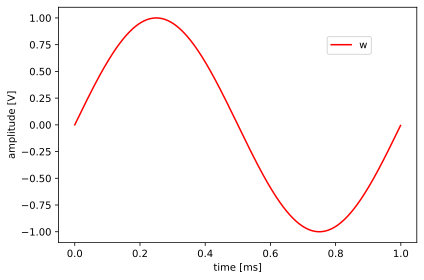

In [3]:
fig_buffer, ax1_buffer = plt.subplots()

ax1_buffer.set_xlabel('time [ms]')
ax1_buffer.set_ylabel('amplitude [V]')
ax1_buffer.plot(linespace, wavetable, color='Red')

ax1_buffer.legend('wave', loc=(0.75,0.8))

plt.tight_layout()
plt.show()

In [4]:
time = 1/440
sample_time = 1/(440*1024)
sample_rate = 1/sample_time
print(time)
print(sample_time)
print(sample_rate)


0.0022727272727272726
2.219460227272727e-06
450560.0


the frequency of the signal is given by the time that is used to replay this waveform. This waveform has 1024 entries. if it should be a 440 Hz tone. The time to play one cycle is 1/440=0.0022727272727272726s. so there must be a value written to the DAC every 1/(440*1024)=450.56Hz.

In [5]:
from IPython.display import Audio
wave_audio = []
linespace = np.arange(0, 1000, (1/1024))
for s in linespace :
    wave_audio.append(np.sin(2*np.pi*s))

print(len(wave_audio))
Audio(wave_audio, rate=sample_rate)

1024000


In [6]:
time = 1/440
sample_time = 1/(220*1024)
sample_rate = 1/sample_time
print(time)
print(sample_time)
print(sample_rate)


0.0022727272727272726
4.438920454545454e-06
225280.0


One way to change the pitch is to change the sample frequency. lets say we want to play the waveform one octave below the frequency is 220Hz and therefore the sample freqency 225.280kHz.

In [7]:
wave_audio = []
linespace = np.arange(0, 1000, (1/1024))
for s in linespace :
    wave_audio.append(np.sin(2*np.pi*s))

print(len(wave_audio))
Audio(wave_audio, rate=sample_rate)

1024000


# Direct digital Synthesis

to change the sample frequency is not a practical way to change the pitch. The sample frequency can not be set accurate enough in a microprossesor and when a polyponic instrument is built.

Another way of chaning the pitch is to not play all values or play then multiple times. This is the basic concept of DDS. DDS provides an efficient algorithm to change the pitch. DDS is often described with a circle. 

In [8]:
wavetable = []
tunes = ''

tunes += "uint16_t wavetable[1024] = {"

rows = 0
linespace = np.arange(0, 1, (1/1024))
for s in linespace :
    tunes += "% .0d, " %((np.sin(2*np.pi*s)+1) * 2048 )
    if rows > 7 :
      rows = 0
      tunes += "\r\n"
    rows = rows + 1

tunes += "};"

display(HTML('''
<pre>%s</pre>
''' % tunes ))

In [9]:
print(360/120*119)

357.0


processing PDF file
  graphic size: 706.629962pt x 661.102874pt (248.352028mm x 232.351086mm)
  output written to 5131ff3483b2cd3618248f60ac252580.svg
1 of 1 page converted in 0.203001 seconds


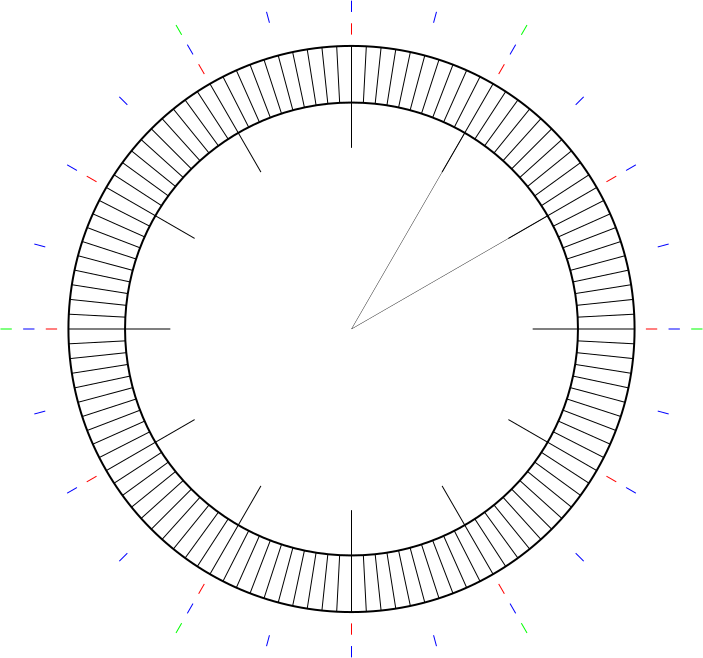

In [10]:
%%itikz --temp-dir 
\documentclass[tikz]{standalone}
\usetikzlibrary{arrows.meta}
\begin{document}
\begin{tikzpicture}[scale=4]

\fontsize{0.35cm}{0.35cm}\selectfont \sffamily
\foreach \angle in {0,30,60,...,330}
    \draw[line width=1pt] (\angle:1.6cm) -- (\angle:2cm);
    
\foreach \angle in {0,3,6,...,357}
    \draw[line width=1pt] (\angle:2cm) -- (\angle:2.5cm);

\foreach \angle in {0,30,60,...,330}
    \draw[line width=1pt,red] (\angle:2.6cm) -- (\angle:2.7cm);

\foreach \angle in {0,15,30,...,345}
    \draw[line width=1pt,blue] (\angle:2.8cm) -- (\angle:2.9cm);

\foreach \angle in {0,60,120,...,300}
    \draw[line width=1pt,green] (\angle:3.0cm) -- (\angle:3.1cm);

\draw[line width=2pt] (0,0) circle (2);
\draw[line width=2pt] (0,0) circle (2.5);

\draw (0,0) -- ++(30:2cm)
      (0,0) -- ++(60:2cm);
    
\end{tikzpicture}
\end{document}



In the circle we would have a wavetable with 12 samples. To make the picture a little bit clearer the number of samples is reduced. The outer ring is the phase accumulator. The accumulator has more steps then the wavetable, here every step in the table has 10 steps in the accumulator. we use the accumulator to derive the entry in the table. if we want to play a 440Hz note. we have to add 10 to the accumulator. as a result every value is played once. If the pitch is 220Hz we add five and play every value twice and for 880Hz we add twenty and skip every other value.  


to get the right value we will have to calculate the increment of the accumulator first. 

In [11]:
tunes = ''
rows = 0;
tunes += "uint32_t tunes[256] = {"
for i in range(256):
    note = 1.0
    note = 440.0*((2.0)**(1.0/12.0))**(i-69.0)  
    increment = pow(2, 32) * note / (40000)
    tunes += "% .0f, " %(increment)
    if rows > 7 :
      rows = 0
      tunes += "\r\n"
    rows = rows + 1

tunes += "};"

display(HTML('''
<pre>%s</pre>
''' % tunes ))

In [12]:
a_tunes = []
for i in range(256):
    note = 1.0
    note = 440.0*((2.0)**(1.0/12.0))**(i-69.0)  
    increment = pow(2, 32) * note / (40000)
    a_tunes.append(increment)

print(a_tunes[69])
print(pow(2, 32))
print(pow(2, 32) >> 22 )

47244640.256
4294967296
1024


The midi note for A (440Hz) is 69, so the increment for the accumulator is 47244640.256.

lets try that alltogheter.

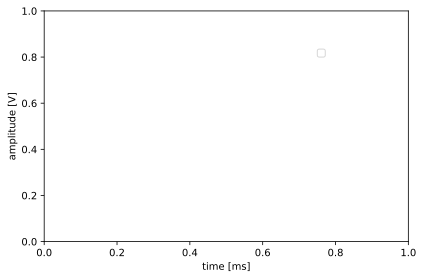

In [16]:
result = []
result2 = []
accumulator = int(0)
accumulator_steps = int(pow(2, 32))

#for i in np.arange(0,200) :
#    acc = (accumulator >> 22)
#    result.append(wavetable[acc])
#    accumulator += int(a_tunes[69])
#    if accumulator > accumulator_steps :
#        accumulator =  accumulator - accumulator_steps
        
accumulator = int(0)
#for i in np.arange(0,200) :
#    acc = (accumulator >> 22)
#    result2.append(wavetable[acc])
#    accumulator += int(a_tunes[57])
#    if accumulator > accumulator_steps :
#        accumulator =  accumulator - accumulator_steps
        
fig_buffer, ax1_buffer = plt.subplots()

ax1_buffer.set_xlabel('time [ms]')
ax1_buffer.set_ylabel('amplitude [V]')
#ax1_buffer.plot(np.arange(0,200), result, color='Red')
#ax1_buffer.plot(np.arange(0,200), result2, color='Blue')

ax1_buffer.legend(('440Hz', '220Hz'), loc=(0.75,0.8))

plt.tight_layout()
plt.show()        

# STM32 implementation




# references

- [Elliot Williams](https://hackaday.com/2016/02/12/embed-with-elliot-audio-playback-with-direct-digital-synthesis) AUDIO PLAYBACK WITH DIRECT DIGITAL SYNTHESIS
